<a href="https://colab.research.google.com/github/sturu1/FRI/blob/master/2020_7_24_%EC%98%A4%ED%9B%84%EC%88%98%EC%97%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import sys
assert sys.version_info >= (3,5)

import sklearn
assert sklearn.__version__ >= "0.20"

In [49]:
try:
  %tensorflow_version 2.x
  IS_COLAB = True
except Exception:
  IS_COLAB = False

In [50]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >="2.0"

if not tf.config.list_physical_devices('GPU'):
  print('No')
  if IS_COLAB:
    print('Go')

No
Go


In [51]:
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "CNN"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fog_extension="png", resolution=300):
  path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
  print("Saving figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

In [52]:
def plot_image(image):
  plt.imshow(image, cmap='gray', interpolation="nearest")
  plt.axis("off")

def plot_color_image(image):
  plt.imshow(image, interpolation="nearest")
  plt.axis("off")

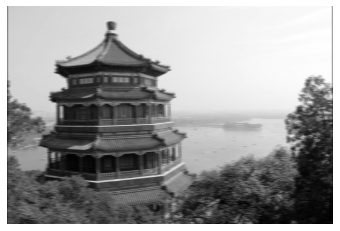

In [53]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap='gray')
plt.axis("off")
plt.show()

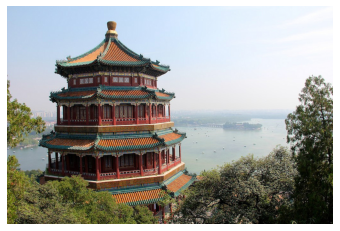

In [54]:
plt.imshow(china, cmap='gray')
plt.axis("off")
plt.show()

In [55]:
filters

array([[[[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[1., 0.],
         [1., 0.],
         [1., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]]],


       [[[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 

In [56]:
filters.shape

(7, 7, 3, 2)

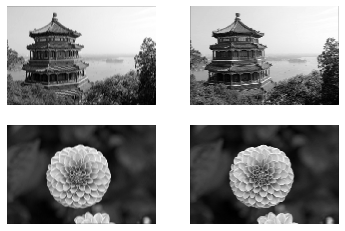

In [57]:
for image_index in (0, 1):
  for feature_map_index in (0, 1):
    plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
    plot_image(outputs[image_index, :, :, feature_map_index])
plt.show()

In [58]:
def crop(images):
  return images[150:220, 130:250]

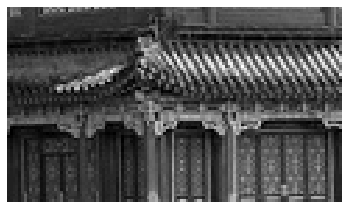

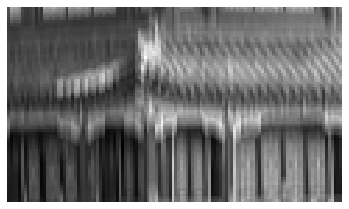

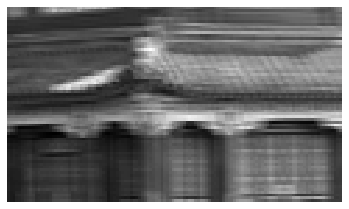

In [59]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(['china_ve', 'china_ho']):
  plot_image(crop(outputs[0, :, :, feature_map_index]))
  plt.show()

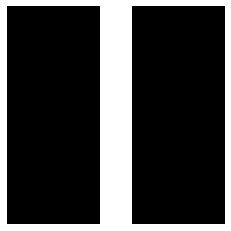

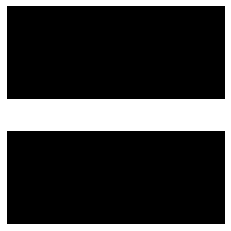

In [60]:
plot_image(filters[:, :, 0, 0])
plt.show()

plot_image(filters[:, :, 0, 1])
plt.show()

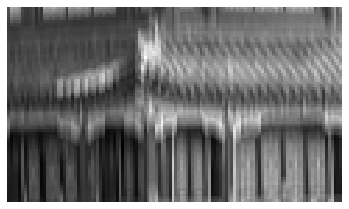

In [61]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="SAME", activation="relu")
plot_image(crop(outputs[0, :, :, 0]))
plt.show()


In [62]:
def feature_map_size(input_size, kernel_size, strides=1, padding="SAME"):
  if padding == "SAME":
    return (input_size -1) // strides + 1
  else:
    return (input_size - kernel_size) // strides + 1

In [63]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
  fmap_size = feature_map_size(input_size, kernel_size, strides)
  padded_size = max((fmap_size - 1) * strides + kernel_size, input_size)
  pad_before = (padded_size - input_size) // 2
  return pad_before, padded_size

In [64]:
def manual_same_padding(images, kernel_size, strides=1):
  if kernel_size == 1:
    return images.astype(np.float32)
  batch_size, height, width, channels = images.shape
  top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
  left_pad, padded_width = pad_before_and_padded_size(width, kernel_size, strides)
  padded_shape = [batch_size, padded_height, padded_width, channels]
  padded_image = np.zeros(padded_shape, dtype=np.float32)
  padded_image[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
  return padded_image

In [65]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

conv_same.build(tf.TensorShape(images.shape))
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

In [66]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [67]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

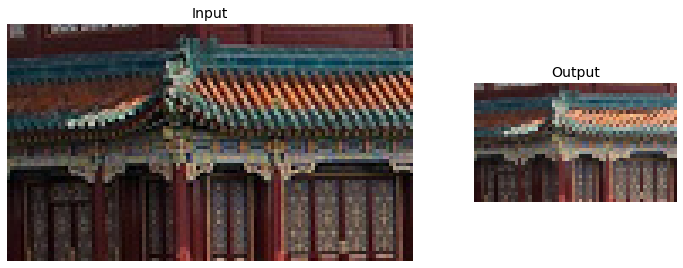

In [68]:
fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2,1])

ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[0,1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])
ax2.axis("off")

plt.show()

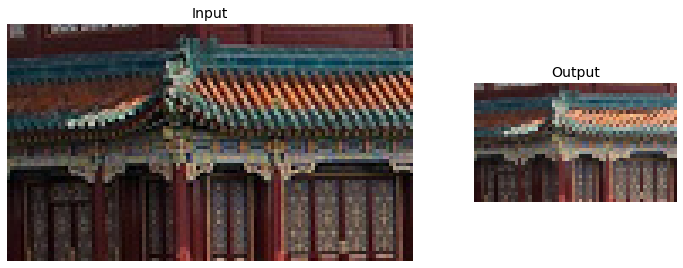

In [69]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

output_avg =avg_pool(cropped_images)

fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2,1])

ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[0,1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])
ax2.axis("off")

plt.show()

In [70]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7

X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[...,np.newaxis]
X_valid = X_valid[...,np.newaxis]
X_test = X_test[...,np.newaxis]

In [71]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([DefaultConv2D(filters=64, kernel_size=7, input_shape=[28,28,1]),
                                 keras.layers.MaxPool2D(pool_size=2),
                                 DefaultConv2D(filters=128),
                                 DefaultConv2D(filters=128),
                                 keras.layers.MaxPool2D(pool_size=2),
                                 DefaultConv2D(filters=256),
                                 DefaultConv2D(filters=256),
                                 keras.layers.MaxPool2D(pool_size=2),
                                 keras.layers.Flatten(),
                                 keras.layers.Dense(units=128, activation='relu'),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(units=64, activation='relu'),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(units=10, activation='relu'),
                                 ])

In [72]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 7, 7, 256)        

In [73]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_train, y_valid))

157/157 [==============================] - 84s 532ms/step - loss: 7.0544 - accuracy: 0.0926 - val_loss: 5.3971 - val_accuracy: 0.1008


In [74]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, padding='SAME', use_bias=False)

class ResidualUnit(keras.layers.Layer):
  def __init__(self, filters, strides=1, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [DefaultConv2D(filters, strides=strides), keras.layers.BatchNormalization(), self.activation,
                        DefaultConv2D(filters), keras.layers.BatchNormalization(),
                        ]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [DefaultConv2D(filters, kernel_size=1, strides=strides),
                          keras.layers.BatchNormalization()]
  def call(self, inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
    skip_Z = inputs
    for layer in self.skip_layers:
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [75]:
model = keras.models.Sequential()

model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224,224,3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='SAME'))
prev_filters = 64

for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

In [76]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_72 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_32 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_33 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_34 (ResidualUn (None, 56, 56, 64)       